## Example calculation of a dose response curve

The used code originates from Kobrosly's packages 'Causal Curve' which can be found here:
\ https://github.com/ronikobrosly/causal-curve
\
\
Parts of the package have be taken apart to understand and demontrate how they are working.

### Preparation

In [1]:
import os
import warnings; warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
from scipy.interpolate import interp1d

from causal_curve import GPS_Regressor
from causal_curve import Mediation


%matplotlib inline
pd.options.mode.chained_assignment = None
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = [5, 4]

In [12]:
from scipy.stats import gamma, norm
import statsmodels.api as sm
from statsmodels.genmod.families.links import inverse_power as Inverse_Power
from statsmodels.tools.tools import add_constant
from pygam import LinearGAM, s
import contextlib
import io
import matplotlib.pyplot as plt

load dataset

In [22]:
df = pd.read_csv('data/main/data_set.csv')

In [8]:
df.head(1)

,company,assets_2018,assets_2019,assets_2020,assets_2021,cash_2018,cash_2019,cash_2020,cash_2021,cash_ratio_2018,...,days_loan_2022,size,industry_1,industry_2,aid_relative_2021,delta_cash_ratio_2021,delta_cash_2021,delta_quick_ratio_2021,delta_current_ratio_2021,delta_equity_ratio_2021
0,"""capillar gmbh""",2332299.34,NaN,2732777.71,NaN,36787.77,NaN,233693.31,NaN,0.015773,...,NaN,Kleine und mittlere Unternehmen,Handel; Instandhaltung und Reparatur von Kraft...,Einzelhandel (ohne Handel mit Kraftfahrzeugen),NaN,NaN,NaN,NaN,NaN,NaN


Calculation of the delta in aid and for selected ratios between 2020 and 2021

In [23]:
df['aid_relative_2021'] = df['aid_grant_2021'] / df['assets_2021']

df['delta_cash_ratio_2021'] = (df['cash_ratio_2021'] - df['cash_ratio_2020'])
df['delta_cash_2021'] = (df['cash_2021'] - df['cash_2020'])
df['delta_quick_ratio_2021'] = (df['quick_ratio_2021'] - df['quick_ratio_2020'])
df['delta_current_ratio_2021'] = (df['current_ratio_2021'] - df['current_ratio_2020'])
df['delta_equity_ratio_2021'] = (df['equity_ratio_2021'] - df['equity_ratio_2020'])

Code for preparing Size of the companies as a dummy variable (Large /SME)

In [24]:
condounders = pd.get_dummies(df["size"], prefix='size', drop_first=True)
condounders.columns = condounders.columns.str.replace(' ', '_')
list(condounders.columns)

['size_nur_Großunternehmen']

Preparing the data:
- Replacing NaNs
- Adding the dummy variable

In [48]:
df = df[['delta_cash_ratio_2021',
    'delta_quick_ratio_2021',
    'delta_current_ratio_2021',
    'delta_equity_ratio_2021',
    'debt/asset_ratio_2020',
    'cash_ratio_2020', 
    'size',    
    'industry_2',
    'delta_cash_2021',
    'aid_grant_2021',
    'aid_grant_2020',
    'aid_loan_2021',
    'days_grant_2021',
    'aid_loan_2020',
    'assets_2020',
    'aid_relative_2021']]

df['aid_grant_2021'].replace(np.nan, 0, inplace=True)
df['aid_loan_2021'].replace(np.nan, 0, inplace=True)
df['aid_loan_2020'].replace(np.nan, 0, inplace=True)
df['aid_grant_2020'].replace(np.nan, 0, inplace=True)
df['assets_2020'].replace(np.nan, 0, inplace=True)
df['delta_cash_2021'].replace(np.nan, 0, inplace=True)
df['days_grant_2021'].replace(np.nan, 0, inplace=True)
df['debt/asset_ratio_2020'].replace(np.nan, 0, inplace=True)

final_df = pd.concat([df,pd.get_dummies(df["size"], prefix='size', drop_first=True)],axis = 1)
final_df.columns = final_df.columns.str.replace(' ', '_')

final_df.replace([np.inf, -np.inf], np.nan, inplace=True)
final_df = final_df.dropna()

Add more possible confounders into the list: 



First, the leverage of companies, represented by the debt to asset ratio in 2020.


Next, other aid payments which also impacted the liquidity of companies:
- loans in 2020 and 2021
- grant from the previous year (2020)

In [49]:
potential_confounders = list(condounders.columns)
potential_confounders.append('aid_loan_2021')
potential_confounders.append('aid_loan_2020')
potential_confounders.append('aid_grant_2020')
potential_confounders.append('debt/asset_ratio_2020')
potential_confounders.append('days_grant_2021')
potential_confounders

['size_nur_Großunternehmen',
 'aid_loan_2021',
 'aid_loan_2020',
 'aid_grant_2020',
 'debt/asset_ratio_2020',
 'days_grant_2021']

prepare variables for model:

- T: Treatment Variable is the grant in 2021

- X: The potential coundounders are used as covariates

- y: is the observed Outcome represented by the change in cash

In [50]:
T=final_df['aid_grant_2021'] 
X=final_df[potential_confounders]
y=final_df['delta_cash_2021']

### Calculate GPS

Create probability density function for GPS based on linear/gaussian GLM

In [51]:
"""Models the GPS using a GLM of the Gaussian family"""
normal_gps_model = sm.GLM(T, add_constant(X), family=sm.families.Gaussian()).fit()

pred_treat = normal_gps_model.fittedvalues
sigma = np.std(normal_gps_model.resid_response)

def gps_function(treatment_val, pred_treat=pred_treat, sigma=sigma):
    return norm.pdf(treatment_val, pred_treat, sigma)

Estimate the Generalized propensity scores

In [52]:
gps = gps_function(T)

For 3922 observations (Aid payments for companies) were Generalized propensity scores were calculated

In [108]:
gps.shape

(3922,)

### Run a GAM on the outcome and the treatment + GPS 

Create generalized additive model (GAM) that predicts outcome from the treatment and GPS

In [98]:
X_GAM = np.column_stack((T.values, gps))
y_GAM = np.asarray(y)

n_splines=30
spline_order=3
max_iter=100
lambda_=0.5

gam_results = LinearGAM(s(0,n_splines=n_splines, spline_order=spline_order) 
                        + s(1,n_splines=n_splines, spline_order=spline_order),
                        max_iter=max_iter,
                        lam=lambda_
                        ).fit(X_GAM, y_GAM)

### Estimation of the causal dose response at different levels

Preparation: 
- treatment_grid_num: The the causal response will be estimates at 100 levels
- lower-/ upper_grid_constraint: truncates the lowest 1 % and the highes 10 % to remove extreme observations
- grid_values: array with the 100 defined levels
- gps_at_grid: array of shape (n_samples, treatment_grid_num)

In [117]:
treatment_grid_num = 100
lower_grid_constraint = 0.01
upper_grid_constraint = 0.90
grid_values = np.quantile(T,q=np.linspace(start=lower_grid_constraint,
                                          stop=upper_grid_constraint,
                                          num=treatment_grid_num,),)

gps_at_grid = np.zeros((len(T), treatment_grid_num), dtype=float)

Fill the Grid with GPS

In [119]:
for i in range(0, treatment_grid_num):
    gps_at_grid[:, i] = gps_function(grid_values[i])

Predictions using the original treatment and gps_at_grid:

In [122]:
## Explanation from the author (Roni Kobrosly)
# To keep track of cdrc predictions, we create an empty 3d array of shape
# (n_samples, treatment_grid_num, 3). The last dimension is of length 3 because
# we are going to keep track of the point estimate of the prediction, as well as
# the lower and upper bounds of the prediction interval
cdrc_preds = np.zeros((len(T), treatment_grid_num, 3), dtype=float)


# Loop through each of the grid values, predict point estimate and get prediction interval
for i in range(0, treatment_grid_num):
    temp_T = np.repeat(grid_values[i], repeats=len(T))
    temp_gps = gps_at_grid[:, i]
    temp_cdrc_preds = gam_results.predict(
        np.column_stack((temp_T, temp_gps))
    )
    temp_cdrc_interval = gam_results.confidence_intervals(
        np.column_stack((temp_T, temp_gps)), width=0.95 # Confidence intercall
    )
    temp_cdrc_lower_bound = temp_cdrc_interval[:, 0]
    temp_cdrc_upper_bound = temp_cdrc_interval[:, 1]
    cdrc_preds[:, i, 0] = temp_cdrc_preds
    cdrc_preds[:, i, 1] = temp_cdrc_lower_bound
    cdrc_preds[:, i, 2] = temp_cdrc_upper_bound

cdrc_preds = np.round(cdrc_preds, 3)

The predictions and the CIs are then stored into a dataframe:

In [123]:
results = []

for i in range(0, treatment_grid_num):
    temp_grid_value = grid_values[i]
    temp_point_estimate = cdrc_preds[:, i, 0].mean()
    mean_ci_width = (
        cdrc_preds[:, i, 2].mean() - cdrc_preds[:, i, 1].mean()) / 2
    temp_lower_bound = temp_point_estimate - mean_ci_width
    temp_upper_bound = temp_point_estimate + mean_ci_width
    results.append(
        [
            temp_grid_value,
            temp_point_estimate,
            temp_lower_bound,
            temp_upper_bound,
        ])

outcome_name = "Causal_Dose_Response"
results = pd.DataFrame(results, columns=["Treatment", outcome_name, "Lower_CI", "Upper_CI"]).round(3)

Predictions of causal dose response curve for each value of the treatment grid:

In [125]:
results.head(5)

,Treatment,Causal_Dose_Response,Lower_CI,Upper_CI
0,100995.705,46371.624,-13995.533,106738.782
1,102236.858,46312.367,-13576.058,106200.792
2,103569.797,46256.445,-13132.365,105645.255
3,105462.905,46192.023,-12513.672,104897.718
4,107004.114,46153.693,-12019.086,104326.471


### Plotting the dose response curve

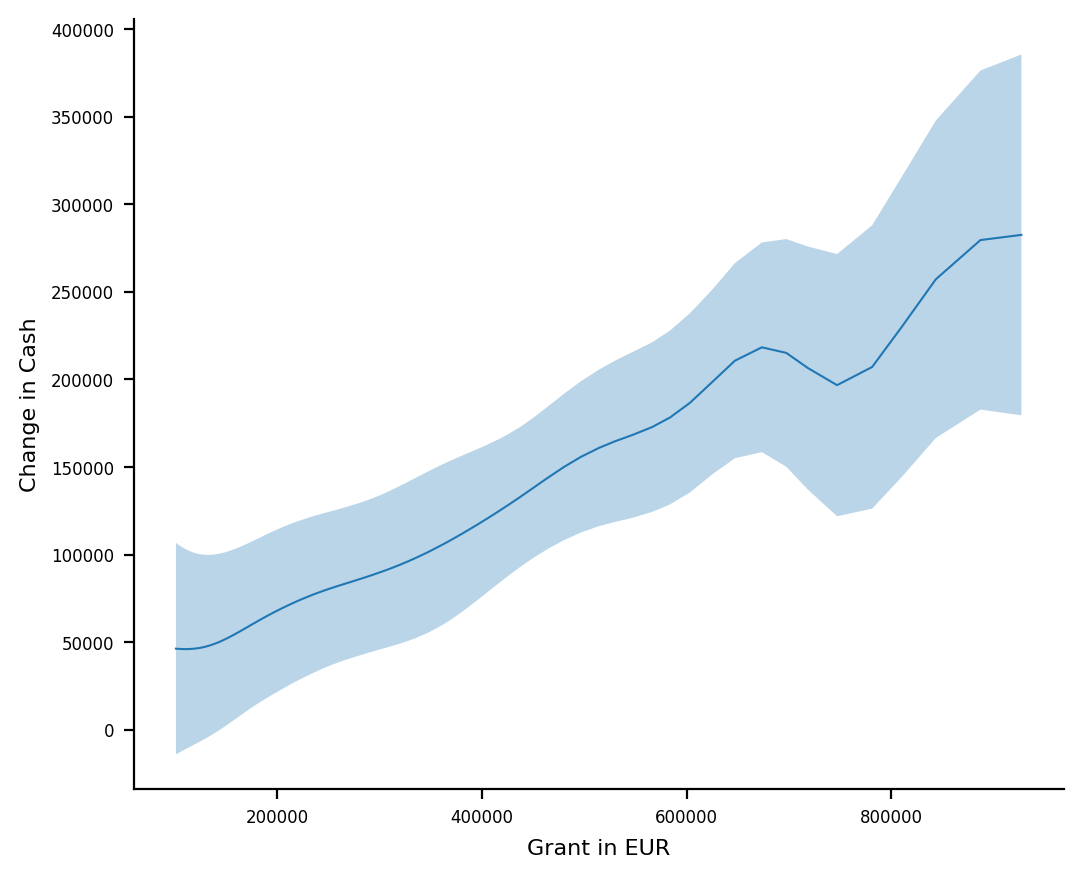

In [102]:
treat = results['Treatment']
mean = results['Causal_Dose_Response']
lb = results['Lower_CI']
ub = results['Upper_CI']
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = [6, 5]
fig, axs = plt.subplots()
axs.fill_between(treat, lb, ub, alpha=0.3)
axs.plot(treat, mean, linewidth=0.75)
axs.spines["top"].set_visible(False)
axs.spines["right"].set_visible(False)
axs.set_ylabel('Change in Cash', fontsize = 8)
axs.set_xlabel('Grant in EUR', fontsize = 8)
axs.tick_params(axis='both', which='major', labelsize=6)